In [1]:
import numpy as np
import json
from datetime import datetime

from shapely import geometry as sgeom
import geopandas as gpd
import ulmo
import pandas as pd
from collections import OrderedDict

In [2]:
#paths 
########## USER ###########
# Select modeling domain
domain = 'WY'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY/'

metFname = 'mm_WY_2018-2019.dat'

In [3]:
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/Aragon2/Notebooks/calibration_python'
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'

#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()
    
#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()
    
#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)
    
#base .par
with open('/nfs/attic/dfh/Aragon2/CSOdmn/par_base.json') as f:
    base = json.load(f)

## SM run w/o assim 

This will be the baseline we will use to compare various assim runs

In [29]:
# setup SM run w/o assim
edit_par(base,'met_input_fname','../CSOdmn/'+domain+'/'+metFname)
edit_par(base,'iyear_init',metFname[6:10])
edit_par(base,'max_iter',(datetime.strptime(metFname[11:15]+'-09-30','%Y-%m-%d')-
                          datetime.strptime(metFname[6:10]+'-09-01','%Y-%m-%d')).days*4+4)

#run compile script 
#Compile SnowModel
%cd $codepath
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


## SM run assim 1/2 of SNOTEL

1/2 SNOTEL will be assimilated, 1/2 will not

Stations not assimilated will be used to evaluate enhanced performance of assimilation

In [4]:
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

In [5]:
#function to extract data
def sites_asgdf(ulmo_getsites, crs=stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [6]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

In [7]:
# WaterML/WOF WSDL endpoint url 
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)

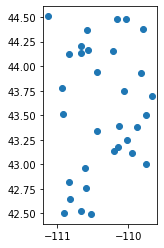

In [8]:
gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
gdf.drop(columns='index_right', inplace=True)
gdf.reset_index(drop=True, inplace=True)
#CSO_gdf.index = CSO_gdf['code']

#add columns with projected coordinates 
proj = gdf.to_crs(mod_proj)
gdf['easting'] = proj.geometry.x
gdf['northing'] = proj.geometry.y

gdf.plot()

In [9]:
sample = gdf.sample(n=int(len(gdf)/2))

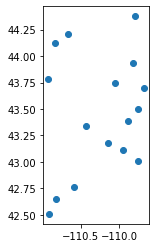

In [10]:
sample.plot()

In [11]:
sample

,code,longitude,latitude,name,elevation_m,geometry,easting,northing
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,POINT (-109.67021 43.69733),607155.527746,4.839116e+06
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,POINT (-109.79333 44.37667),596129.923439,4.914418e+06
9,1082_WY_SNTL,-110.927834,43.779331,Grand Targhee,2822.447998046875,POINT (-110.92783 43.77933),505807.281569,4.847367e+06
31,878_WY_SNTL,-109.817749,43.932251,Younts Peak,2545.080078125,POINT (-109.81775 43.93225),594893.973880,4.865027e+06
27,822_WY_SNTL,-110.057800,43.749020,Togwotee Pass,2919.98388671875,POINT (-110.05780 43.74902),575857.882766,4.844429e+06
10,497_WY_SNTL,-110.434952,43.342979,Granite Creek,2063.49609375,POINT (-110.43495 43.34298),545799.195781,4.799058e+06
8,468_WY_SNTL,-109.758926,43.006569,Elkhart Park G.S.,2865.1201171875,POINT (-109.75893 43.00657),601147.651582,4.762292e+06
28,831_WY_SNTL,-110.591400,42.763931,Triple Peak,2590.800048828125,POINT (-110.59140 42.76393),533431.538150,4.734681e+06
16,585_WY_SNTL,-109.751999,43.502781,Little Warm,2855.97607421875,POINT (-109.75200 43.50278),600889.610102,4.817407e+06
20,730_WY_SNTL,-110.909897,42.507500,Salt River Summit,2328.672119140625,POINT (-110.90990 42.50750),507402.542749,4.706130e+06


In [12]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [13]:
st = metFname[6:10]+'-09-01'
ed = metFname[11:15]+'-09-30'

stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in sample.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        #check for nan values
        if len(swe.value[np.isnan(swe.value)]) > 0:
            #check if more than 10% of data is missing
            if len(swe.value[np.isnan(swe.value)])/len(swe) > .1:
                print('More than 10% of days missing')
                gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)
                continue
        stn_swe[sitecode] = swe.value
    except:
        gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)
        sample.drop(sample.loc[sample['code']==sitecode].index, inplace=True)
        
stn_swe

379_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
350_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
1082_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
878_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
822_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
497_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
468_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
831_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
585_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
730_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
944_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
661_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
597_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
577_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
499_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
419_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30


,379_WY_SNTL,350_WY_SNTL,1082_WY_SNTL,878_WY_SNTL,822_WY_SNTL,497_WY_SNTL,468_WY_SNTL,831_WY_SNTL,585_WY_SNTL,730_WY_SNTL,944_WY_SNTL,661_WY_SNTL,597_WY_SNTL,577_WY_SNTL,499_WY_SNTL,419_WY_SNTL
2018-09-01,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,0.0,0.0,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-27,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-28,0.0,0.2,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-29,0.3,1.0,1.9,0.7,1.4,0.0,0.0,0.0,1.0,0.0,0.9,0.0,0.0,0.0,0.0,0.0


In [14]:
sample = sample.reset_index(drop=True)
for sitecode in sample.code:
    # overwrite the original values (no use for the original values in inches)
    stn_swe[sitecode] = 0.0254 * stn_swe[sitecode]

In [15]:
new = stn_swe.iloc[::10, :]
new

,379_WY_SNTL,350_WY_SNTL,1082_WY_SNTL,878_WY_SNTL,822_WY_SNTL,497_WY_SNTL,468_WY_SNTL,831_WY_SNTL,585_WY_SNTL,730_WY_SNTL,944_WY_SNTL,661_WY_SNTL,597_WY_SNTL,577_WY_SNTL,499_WY_SNTL,419_WY_SNTL
2018-09-01,0.00000,0.00254,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-09-11,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-09-21,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-10-01,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-10-11,0.00254,0.02032,0.02540,0.00000,0.00762,0.00000,0.01778,0.00000,0.00000,0.00254,0.00000,0.00508,0.00000,0.00000,0.00508,0.00000
2018-10-21,0.00000,0.04064,0.04064,0.00508,0.02032,0.00000,0.02794,0.01270,0.00508,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-10-31,0.00000,0.07366,0.07112,0.00000,0.03556,0.00000,0.02540,0.01270,0.00000,0.00000,0.00254,0.00000,0.00000,0.00508,0.00508,0.00000
2018-11-10,0.01778,0.14224,0.19050,0.02794,0.11684,0.02540,0.04064,0.08382,0.01270,0.01016,0.02794,0.02286,0.03556,0.04826,0.05334,0.06096
2018-11-20,0.03810,0.15748,0.20320,0.04064,0.13462,0.03302,0.05334,0.09144,0.03810,0.01778,0.04318,0.03302,0.05080,0.05080,0.06858,0.06858
2018-11-30,0.05588,0.21336,0.33782,0.07620,0.17780,0.07874,0.07620,0.15240,0.04572,0.05842,0.06858,0.05588,0.09144,0.13716,0.15240,0.12192


In [16]:
# save out data not being assimilated 

# save out data being assimilated
out = assimPath + 'assim_SNOTEL_sites.geojson'
sample.to_file(out, driver='GeoJSON')

out = assimPath + 'assim_SNOTEL_data_SWEDmeters.csv'
new.to_csv(out)

/nfs/attic/dfh/Aragon2/CSOassim/WY/assim_SNOTEL_sites.geojson: No such file or directory
driver GeoJSON does not support creation option ENCODING


In [17]:
sample

,code,longitude,latitude,name,elevation_m,geometry,easting,northing
0,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,POINT (-109.67021 43.69733),607155.527746,4.839116e+06
1,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,POINT (-109.79333 44.37667),596129.923439,4.914418e+06
2,1082_WY_SNTL,-110.927834,43.779331,Grand Targhee,2822.447998046875,POINT (-110.92783 43.77933),505807.281569,4.847367e+06
3,878_WY_SNTL,-109.817749,43.932251,Younts Peak,2545.080078125,POINT (-109.81775 43.93225),594893.973880,4.865027e+06
4,822_WY_SNTL,-110.057800,43.749020,Togwotee Pass,2919.98388671875,POINT (-110.05780 43.74902),575857.882766,4.844429e+06
5,497_WY_SNTL,-110.434952,43.342979,Granite Creek,2063.49609375,POINT (-110.43495 43.34298),545799.195781,4.799058e+06
6,468_WY_SNTL,-109.758926,43.006569,Elkhart Park G.S.,2865.1201171875,POINT (-109.75893 43.00657),601147.651582,4.762292e+06
7,831_WY_SNTL,-110.591400,42.763931,Triple Peak,2590.800048828125,POINT (-110.59140 42.76393),533431.538150,4.734681e+06
8,585_WY_SNTL,-109.751999,43.502781,Little Warm,2855.97607421875,POINT (-109.75200 43.50278),600889.610102,4.817407e+06
9,730_WY_SNTL,-110.909897,42.507500,Salt River Summit,2328.672119140625,POINT (-110.90990 42.50750),507402.542749,4.706130e+06


In [21]:
outFpath = 'swe_obs_test.dat'
f= open(outFpath,"w+")
 
    

tot_obs=np.shape(new)[0]*np.shape(new)[1]
uq_day = np.shape(new)[0]
stn = list(new.columns)
f.write('{:02.0f}\n'.format(uq_day))
for j in range(uq_day):
    d=new.index[j].day
    m=new.index[j].month
    y=new.index[j].year
    date = str(y)+' '+str(m)+' '+str(d)
    stn_count = np.shape(new)[1]
    f.write(date+' \n')
    f.write(str(stn_count)+' \n')
    ids = 100
    for k in range(stn_count):
        ids = ids + 1 
        if sample.code[0]==stn[0]:
            x= sample.easting[k]
            y=sample.northing[k]
            swe=new[stn[k]][j]
            f.write('{:3.0f}\t'.format(ids)+'{:10.0f}\t'.format(x)+'{:10.0f}\t'.format(y)+'{:3.2f}\n'.format(swe))
        else:
            print('station mismatch')
f.close() 

In [22]:
assimpath = SMpath+'swe_assim/'
! mv swe_obs_test.dat $assimpath

In [23]:
edit_par(base,'irun_data_assim',1)
edit_par(base,'print_var_18','y')#swed
edit_par(base,'print_var_19','y')#sspr
edit_par(base,'print_var_20','y')#ssmt

replace_line(incFile, 30, '      parameter (max_obs_dates='+str(tot_obs+1)+')\n')

In [24]:
%cd $codepath
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


In [ ]:
# For a DATA ASSIMILATION RUN, MAX_OBS_DATES must be
#  defined in SNOWMODEL.INC to be greater than the
#  number of observation dates in the entire simulation
#  + (plus) the number of years in the simulation.  For
#  example, for a 6-year simulation with two observation
#  dates in each year, you would set max_obs_dates to be
#  at least = 18.


In [ ]:
# SM run assim CSO 